# Simple regression model on time series gravitational wave data

## Load machine learning libraries
To run this notebook you will need to download the library `sktime` (https://www.sktime.org/en/latest/), which downloads the `sklearn` library from 
`sci-kit learn`
(https://scikit-learn.org/stable/index.html) and the `MiniRocket` library (https://github.com/angus924/minirocket).

If you use `conda`, then this can easily be installed via `conda install -c conda-forge sktime`. If you want this library to exist in its own conda environment then you will want to run the following code:
```bash
# creates environment 'ml_sktime'
<< conda create --name ml_sktime
# activate your environment
<< conda activate ml_sktime
# install matplotlib library in this environment
<< conda install matplotlib 
# install sktime library in this environment
<< conda install -c conda-forge sktime
# install library that allows you to run this environment in a notebook
<< conda install -c anaconda ipykernel
# install Jupyter notebook kernel that is associated with this environment
<< python -m ipykernel install --user --name=ml_sktime
```
Note that you can replace the name 'ml_sktime' with any name you want for this environment. I believe this can also be installed via `pip`

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, RidgeClassifierCV
from sktime.transformations.panel.rocket import MiniRocket, MiniRocketMultivariate

## Load gravitational wave time series data

We store the gravitational time series in `gw_series` and the black hole spin associated with these time series in `a_series`

In [421]:
timeSteps = 100000
a_data = pd.DataFrame(columns = ['a'])
gw_series = pd.DataFrame(columns = ['hI'])
gw_series_full = pd.DataFrame(columns = np.arange(timeSteps))
for f in flist:
    if f[-4:] == '.npz':
        data = np.load(gw_dir + f)
        params = data['params'].astype(float)
        hI = data['hI'].astype(float)
        #s = pd.Series(str(int(params[0]>0.7)), index = ['a'])
        s = pd.Series(str(params[0]), index = ['a'])
        s2 = pd.Series([hI[-timeSteps:]], index = ['hI'])
        s3 = pd.Series(hI[-timeSteps:], index = np.arange(timeSteps))
        df = s.to_frame().T
        df2 = s2.to_frame().T
        df3 = s3.to_frame().T
        a_data = a_data.append(df, ignore_index=True)
        gw_series = gw_series.append(df2, ignore_index=True)
        gw_series_full = gw_series_full.append(df3, ignore_index=True)
a_series = a_data['a']

## Train model on gravitational wave time series data

### Split data into training data and test data

In [468]:
X_train, X_test, y_train, y_test = train_test_split(gw_series, a_series)
X_train2, X_test2, y_train2, y_test2 = train_test_split(gw_series_full, a_series)

### Initialize and train transformation model

We make use of the `MiniRocket` model (see https://github.com/angus924/minirocket), which trains the time series on random convolutional neural networks to transform the time series data onto a new set of random features/basis variables. The number of (basis) features is set by `num_features`. We then train the `MiniRocket` model on our training data to produce the neural net basis.

In [469]:
num_features = 10000;
minirocket = MiniRocket(num_features=num_features)  # by default, MiniRocket uses ~10,000 kernels
minirocket.fit(X_train);

Then we need to transform our training and test sets to this new basis

In [470]:
X_train_transform = minirocket.transform(X_train)
X_test_transform = minirocket.transform(X_test);

### Initialize and train classifier

First we can train `RidgeClassifierCV` (a Ridge classification model with cross-validation) on the transformed data

In [471]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train);
classifier2 = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier2.fit(X_train2, y_train2);

### Initialize and train regressor

Next we can train a `RidgeCV` (a Ridge regression model with cross-validation) on the transformed data

In [472]:
regressor = RidgeCV(alphas=np.logspace(-3, 0, 10), normalize=True)
regressor2 = RidgeCV(alphas=np.logspace(-3, 0, 10), normalize=True)
regressor.fit(X_train_transform, y_train.astype(float));
regressor2.fit(X_train2, y_train2.astype(float));

## Test model

### Predict the black hole spin parameter for our test data set

We predict the black hole spin by taking the neural-net-transformed data `X_test_transform` and passing it to our `classifier` and `regessor` models. We then calculate the $R^2$-value of the predicted results by comparing them to the true, known values for our test set

In [546]:
y_pred_class = classifier.predict(X_test_transform)
y_pred_reg = regressor.predict(X_test_transform)
print('$R^2$ for classification model = ' + str(r2_score(y_test.astype(float), y_pred_class.astype(float))))
print('$R^2$ for regression model = ' + str(r2_score(y_test.astype(float), y_pred_reg)))

$R^2$ for classification model = 0.7878681908614473
$R^2$ for regression model = 0.9516630380769734


Below we also predict the black hole spin by taking the original time series data `X_test2` and naively training our `Ridge` models on that data. We then calculate the $R^2$-value of the predicted results by comparing them to the true, known values for our test set. We see these models are much worse when compared to the models that are trained on the transformed data from the `MiniRocket` neural net.

In [548]:
y_pred_class2 = classifier2.predict(X_test2)
y_pred_reg2 = regressor2.predict(X_test2)
print('$R^2$ for classification model = ' + str(r2_score(y_test2.astype(float), y_pred_class2.astype(float))))
print('$R^2$ for regression model = ' + str(r2_score(y_test2.astype(float), y_pred_reg2)))

$R^2$ for classification model = -0.7414362630966242
$R^2$ for regression model = -0.15918670320589223


### Plot predicted values and true values for all test data submitted to classification model

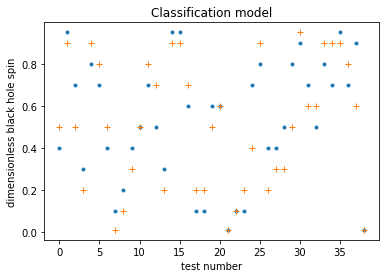

In [549]:
plt.plot(y_test.to_numpy().astype(float), '.', label = 'true')
plt.plot(y_pred_class.astype(float), '+', label = 'predicted')
plt.xlabel('test number')
plt.ylabel('dimensionless black hole spin')
plt.title("Classification model")
plt.show()

### Plot predicted values and true values for all test data submitted to regression model

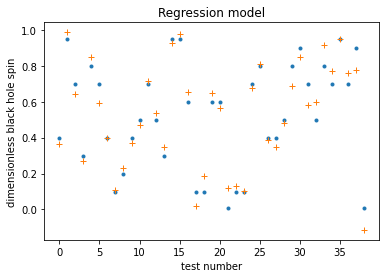

In [550]:
plt.plot(y_test.to_numpy().astype(float), '.')
plt.plot(y_pred_reg.astype(float), '+')
plt.xlabel('test number')
plt.ylabel('dimensionless black hole spin')
plt.title("Regression model")
plt.show()

### Plot predicted values vs true values from both models

The line represents a perfect model in which the predicted values are equivalent to the true values. Visually comparing the predicted values of our regression model (blue dots) and those of the classification model (yellow plus signs), we see that the regression model values are more tightly clustered around the 'perfect' model values, and, therefore, on average does a better job of predicting the 'correct' black hole spin. 

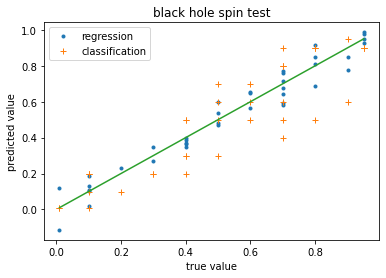

In [551]:
plt.plot(y_test.to_numpy().astype(float), y_pred_reg.astype(float), '.', label = 'regression')
plt.plot(y_test.to_numpy().astype(float), y_pred_class.astype(float), '+', label = 'classification')
plt.plot(np.unique(np.sort(y_test.to_numpy().astype(float))), np.unique(np.sort(y_test.to_numpy().astype(float))), '-')
plt.xlabel('true value')
plt.ylabel('predicted value')
plt.title('black hole spin test')
plt.legend()
plt.show()